In [16]:
! pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [17]:
import os
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image


In [18]:
from typing import TypedDict, Annotated, List, Union

class PlannerState(TypedDict):
    messages: Annotated[
        List[Union[HumanMessage, AIMessage]],
        "the messages in the conversation"
    ]
    city: str
    interests: List[str]
    itinerary: str

In [19]:
from langchain_groq  import ChatGroq
llm=ChatGroq (
    temperature=0 ,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)


In [20]:

itinerary_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful travel assistant. Create a day trip itinerary for {city}."
    ),
    (
        "human",
        "Create an itinerary for my day trip."
    )
])


In [21]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }


def input_interest(state: PlannerState) -> PlannerState:
    # From image_2e3691.png
    print(f"Please enter your interest for the trip to : {state['city']} (comma-separated)")
    user_message = input("Your Input: ")

    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    # From image_2e3a6a.png
    print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")

    response = llm.invoke(itinerary_prompt.format_messages(
        city = state['city'],
        interests = ', '.join(state['interests'])
    ))

    print("\nFinal Itinerary: ")
    print(response.content)

    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary" : response.content,
    }



In [22]:
# Workflow Configuration
workflow = StateGraph(PlannerState)

# Adding the nodes to the graph
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

# Setting the entry point
workflow.set_entry_point("input_city")

# Defining the edges (the flow of the program)
workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# Compiling the workflow into an executable app
app = workflow.compile()

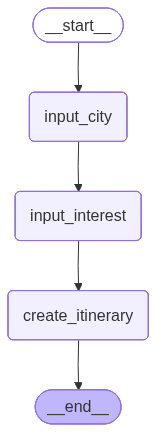

In [23]:
# Visualization


display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [24]:
def travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    for output in app.stream(state):
        pass

In [25]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: mumbai
Please enter your interest for the trip to : mumbai (comma-separated)
Your Input: rani baug
Creating an itinerary for mumbai based on interests : rani baug

Final Itinerary: 
Mumbai, the city that never sleeps. I'd be happy to help you plan a day trip to this vibrant city. Here's a suggested itinerary for you:

**Stop 1: Gateway of India (9:00 am - 10:00 am)**
Start your day with a visit to the iconic Gateway of India, a stunning example of colonial architecture. Take a stroll along the waterfront, and enjoy the street food and street performers.

**Stop 2: Colaba Causeway (10:30 am - 12:00 pm)**
From the Gateway, head to Colaba Causeway, a popular shopping street lined with cafes, restaurants, and street vendors. You can grab a quick breakfast or snack here, and browse through the various shops selling everything from clothes to souvenirs.

**Stop 3: Haji Ali Darg

In [26]:
!pip install gradio

In [27]:
!pip install gtts
import gradio as gr
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from gtts import gTTS
import tempfile

# ---------------- LLM ---------------- #
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",   # 🔑 put your Groq API key
    model_name="llama-3.3-70b-versatile"
)

# ---------------- PROMPT ---------------- #
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """You are a travel expert.
Create a DAY-WISE itinerary with:
- Morning, Afternoon, Evening plan
- Food & activities
- Budget tips
City: {city}
Interests: {interests}
Days: {days}
Budget: {budget}"""),
    ("human", "Create a detailed itinerary.")
])

# ---------------- FUNCTIONS ---------------- #
def travel_planner(city, interests, days, budget):
    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=city,
            interests=", ".join(interests),
            days=days,
            budget=budget or "Not specified"
        )
    )
    return response.content

def text_to_audio(text):
    if not text:
        return None
    tts = gTTS(text)
    audio_file = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3")
    tts.save(audio_file.name)
    return audio_file.name

def update_map(city):
    return f"""
    <iframe
        width="100%" height="300"
        style="border-radius:18px;border:0"
        loading="lazy"
        src="https://www.google.com/maps?q={city.replace(' ','+')}&output=embed">
    </iframe>
    """

# ---------------- CSS ---------------- #
css = """
html, body {
    height: 100%;
    overflow-x: hidden;
    background: #0b132b;
}

/* FIXED BASE BACKGROUND */
#base-bg {
    position: fixed;
    inset: 0;
    background: linear-gradient(120deg, #0b132b, #1c2541);
    z-index: -10;
}

/* FAR BACKGROUND */
body::before {
    content: "";
    position: fixed;
    inset: -20%;
    background: url("https://images.unsplash.com/photo-1501785888041-af3ef285b470") center/cover;
    z-index: -4;
    animation: slowMove 80s linear infinite;
}

/* MID CLOUDS */
body::after {
    content: "";
    position: fixed;
    inset: -10%;
    background: url("https://images.unsplash.com/photo-1499346030926-9a72daac6c63") center/cover;
    opacity: 0.5;
    z-index: -3;
    animation: midMove 45s linear infinite;
}

/* FOREGROUND TRAVELER */
#parallax-foreground {
    position: fixed;
    inset: 0;
    background:
    #0b132b
    url("image.jpg")
    center / cover
    no-repeat
    fixed;

    z-index: -2;
    animation: fastMove 25s ease-in-out infinite;
}

/* GLASS UI */
.glass {
    background: rgba(255,255,255,0.95);
    border-radius: 22px;
    padding: 22px;
    backdrop-filter: blur(10px);
    box-shadow: 0 30px 60px rgba(0,0,0,0.4);
}

button {
    border-radius: 14px !important;
    font-size: 16px !important;
}

/* ANIMATIONS */
@keyframes slowMove {
    from { transform: translateY(0); }
    to { transform: translateY(-120px); }
}

@keyframes midMove {
    from { transform: translateY(0); }
    to { transform: translateY(-220px); }
}

@keyframes fastMove {
    0%,100% { transform: translateY(0); }
    50% { transform: translateY(-90px); }
}
"""

# ---------------- UI ---------------- #
with gr.Blocks(css=css) as demo:

    # fixed layers
    gr.HTML('<div id="base-bg"></div><div id="parallax-foreground"></div>')

    gr.Markdown("""
    # ✈️ AI Travel Planner
    ### Animated Parallax Experience
    """)

    with gr.Row():
        with gr.Column(scale=1):
            with gr.Group(elem_classes="glass"):
                city = gr.Textbox(label="🌍 City", placeholder="Paris")
                interests = gr.CheckboxGroup(
                    label="🎯 Interests",
                    choices=["Food 🍔","History 🏛️","Nature 🌿","Adventure 🧗","Shopping 🛍️"]
                )
                days = gr.Slider(1, 5, value=1, step=1, label="📅 Days")
                budget = gr.Textbox(label="💰 Budget")
                generate = gr.Button("✨ Generate Itinerary")

        with gr.Column(scale=2):
            with gr.Group(elem_classes="glass"):
                with gr.Accordion("🗺️ Itinerary", open=True):
                    output = gr.Markdown()
                with gr.Accordion("📍 Map", open=True):
                    map_view = gr.HTML()
                audio_btn = gr.Button("🔊 Listen to Itinerary")
                audio_out = gr.Audio()

    # EVENTS
    generate.click(travel_planner, [city, interests, days, budget], output)
    generate.click(update_map, city, map_view)
    audio_btn.click(text_to_audio, output, audio_out)

demo.launch()


/tmp/ipython-input-2759796520.py:144: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=css) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7e90ac34b484a1de8c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
